In [1]:
import sys
import os

project_root = os.path.abspath('..')
if project_root not in sys.path:
    sys.path.append(project_root)

%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import warnings

from src.features import build_features

warnings.filterwarnings("ignore")
sns.set_style()
plt.rcParams["figure.figsize"] = (12, 6)

# 1. Lectura de bases de datos

En este análisis se utilizarán 2 bases de datos:

- Base de datos de consultas ambulatorias INT
- Base de datos de procedimientos ambulatorios INT

Ambas bases de datos tienen fechas distintas. 

In [3]:
df_diagnosticos = pd.read_csv(
    "../data/processed/datos_limpios_diagnosticos.csv", encoding="latin-1", sep=";"
)
df_diagnosticos = build_features.formatear_fechas_ambulatorio(df_diagnosticos)
df_diagnosticos = build_features.agregar_rango_etario(df_diagnosticos)
df_diagnosticos = build_features.agregar_anio_mes_dia(df_diagnosticos, "fecha_atencion")
df_diagnosticos = df_diagnosticos.sort_values("fecha_atencion")

In [4]:
df_procedimientos = pd.read_csv(
    "../data/processed/datos_limpios_procedimientos.csv", encoding="latin-1", sep=";"
)
df_procedimientos = build_features.formatear_fechas_procedimientos(df_procedimientos)
df_procedimientos = build_features.agregar_anio_mes_dia(
    df_procedimientos, "fecha_realizacion"
)
df_procedimientos = df_procedimientos.sort_values("fecha_realizacion")

fecha_minimo_procedimientos = min(df_procedimientos.fecha_realizacion)
fecha_maximo_procedimientos = max(df_procedimientos.fecha_realizacion)

cols_texto = df_procedimientos.select_dtypes(include="object").apply(
    lambda x: x.str.strip()
)
df_procedimientos.loc[:, cols_texto.columns] = cols_texto

## 1. Analisis de cantidad de consultas y procedimientos

El rango de fechas de diagnosticos es entre 2016-01-04 08:00:00 y  2023-02-07 11:50:03
El rango de fechas de procedimientos es entre 2020-01-02 00:00:00 y  2022-08-31 00:00:00


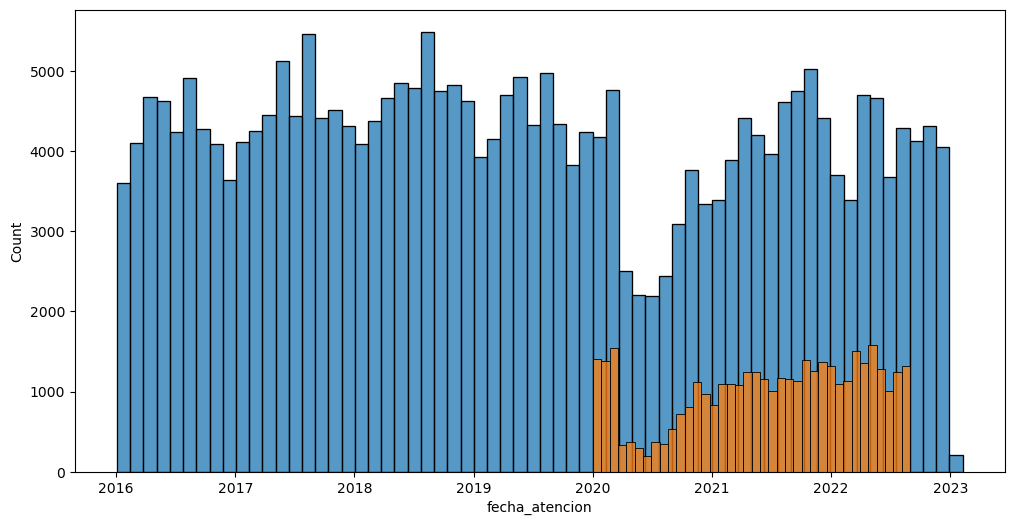

In [5]:
print(
    f"El rango de fechas de diagnosticos es entre {min(df_diagnosticos.fecha_atencion)} y "
    f" {max(df_diagnosticos.fecha_atencion)}"
)
print(
    f"El rango de fechas de procedimientos es entre {fecha_minimo_procedimientos} y "
    f" {fecha_maximo_procedimientos}"
)

sns.histplot(df_diagnosticos["fecha_atencion"])
sns.histplot(df_procedimientos["fecha_realizacion"])
plt.show()

- Por lo tanto, ambas bases deben estar con el mismo rango temporal. Se procedera a filtrar
la base de diagnosticos

In [6]:
mask_fechas = (df_diagnosticos["fecha_atencion"] >= fecha_minimo_procedimientos) & (
    df_diagnosticos["fecha_atencion"] <= fecha_maximo_procedimientos
)

df_diagnosticos_acotado = df_diagnosticos[mask_fechas]

La base de datos de consultas acotada tiene 91916 consultas
La base de datos de procedimeintos tiene 39484 procedimientos


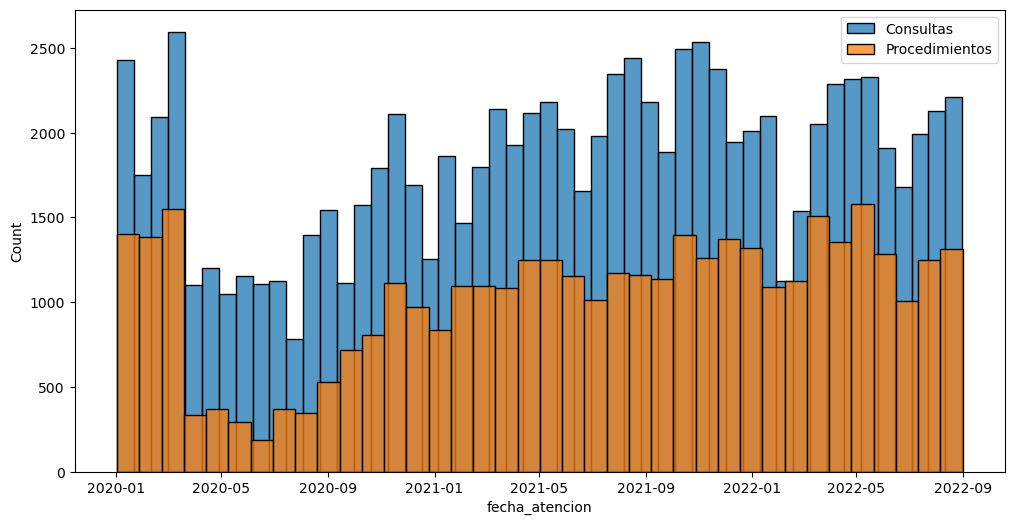

In [7]:
print(
    f"La base de datos de consultas acotada tiene {df_diagnosticos_acotado.shape[0]} consultas"
)
print(
    f"La base de datos de procedimeintos tiene {df_procedimientos.shape[0]} procedimientos"
)

sns.histplot(df_diagnosticos_acotado["fecha_atencion"], label="Consultas")
sns.histplot(df_procedimientos["fecha_realizacion"], label="Procedimientos")
plt.legend()
plt.show()

- Luego, se eliminaran todos los registros que carezcan de una fecha de consulta o procedimientos

In [8]:
df_diagnosticos_acotado = df_diagnosticos_acotado.dropna(subset="fecha_atencion")
df_procedimientos = df_procedimientos.dropna(subset="fecha_realizacion")

print(
    f"La base de datos de consultas acotada tiene {df_diagnosticos_acotado.shape[0]} consultas"
)
print(
    f"La base de datos de procedimeintos tiene {df_procedimientos.shape[0]} procedimientos"
)

La base de datos de consultas acotada tiene 91916 consultas
La base de datos de procedimeintos tiene 39472 procedimientos


- Por lo tanto, la base de consultas carecia de fechas de atencion faltantes. Sin embargo, la
base de procedimientos presentaba 33 fechas faltantes.

## 2. Análisis Sociodemografico a lo largo del tiempo

En este analisis se quieren responder las siguientes preguntas:

1. ¿Cuántas consultas hay por año?
2. ¿Cuáles son los diagnósticos más frecuentes por año?
3. ¿Cuál es el **rango etario** de las personas que se atienden ambulatoriamente en el Hospital del
Tórax? ¿Cómo cambia este perfil por cada uno de los diagnóstico?
4. ¿Cuál es el **género/sexo** de las personas que se atienden ambulatoriamente en el Hospital del
Tórax? ¿Cómo cambia este perfil por cada uno de los diagnósticos?
5. ¿Cuál es la **previsión** de las personas que se atienden ambulatoriamente en el Hospital del
Tórax? ¿Cómo cambia este perfil por cada uno de los diagnósticos?
6. ¿Cuál es el **servicio de salud** de las personas que se atienden ambulatoriamente en el Hospital del
Tórax? ¿Cómo cambia este perfil por cada uno de los diagnósticos?
7. ¿Cuál es la **comuna** de las personas que se atienden ambulatoriamente en el Hospital del
Tórax? ¿Cómo cambia este perfil por cada uno de los diagnósticos?

Para responder estas preguntas se utilizará la base de datos de consultas ambulatorias
del sistema HIS del Instituto Nacional del Tórax. La base de datos contiene consultas desde
el año 2016 al 2022. Esta base contiene los datos para saber la frecuencia por diagnóstico,
rango etario y género.

A pesar de lo anterior, la base de datos de consultas carece de los últimos 3 datos a analizar
(previsón, servicio de salud y comuna de residencia). Debido a esta razón, se utilizará la base
de datos estadística/procedimientos para extraer estos datos.

Producto de lo anterior, surgen las siguientes consideración a tener:

1. ¿Qué pasa si es que un paciente se cambió de comuna/previsión/servicio de salud?
2. ¿Qué ocurre con los pacientes que tienen una consulta, pero que jamás se hayan hecho un
procedimiento?
3. ¿Qué ocurre con los pacientes que tienen un procedimiento, pero que jamás se hayan hecho
una consulta?

Debido a lo anterior, es necesario validar ciertos puntos de las bases de datos.

### 2.1 Obtención de datos de comuna/previsión/servicio de salud por paciente

Estos datos se pueden obtener desde la base de datos de procedimientos/datos estadísticos del
INT. El único detalle que puede existir al extraer estos datos es:

- **¿Qué pasa si un paciente se cambió de comuna/previsión/servicio de salud?**

Para abordar tal detalle, se elegirá el primer registro del paciente en la base de datos (el más
antiguo)

In [9]:
df_procedimientos = df_procedimientos.sort_values("fecha_realizacion")
display(df_procedimientos.fecha_realizacion)

18599   2020-01-02
418     2020-01-02
26452   2020-01-02
417     2020-01-02
18602   2020-01-02
           ...    
18001   2022-08-31
18547   2022-08-31
33341   2022-08-31
18561   2022-08-31
20706   2022-08-31
Name: fecha_realizacion, Length: 39472, dtype: datetime64[ns]

Los datos anteriores indican que las fechas de los procedimientos se encuentran ordenados
de forma ascendente. Además, existen 39472 procedimientos realizados.

Con este control de calidad ya realizado, es posible extraer los datos de pacientes únicos.

In [10]:
datos_pacientes = (
    df_procedimientos.value_counts(
        ["id_paciente", "comuna_residencia", "prevision", "servicio_salud"]
    )
    .reset_index()
    .drop(columns=0)
)

indices_pacientes_unicos = datos_pacientes.groupby("id_paciente").head(1).index
pacientes_unicos = datos_pacientes.iloc[indices_pacientes_unicos]

In [11]:
print(
    f"La cantidad de pacientes repetidos en los datos unicos son: "
    f"{pacientes_unicos.id_paciente.duplicated().sum()}"
)

La cantidad de pacientes repetidos en los datos unicos son: 0


Una vez sabiendo que sólamente existen datos únicos para los pacientes, entonces estos se pueden
unir a la base de datos de consultas. Sin embargo, debemos saber cuántos de los pacientes que se
han realizado un procedimiento se han realizado una consulta.

In [12]:
pacientes_unicos_consulta = set(df_diagnosticos_acotado.id_paciente.unique())
pacientes_unicos_procedimientos = set(pacientes_unicos.id_paciente.unique())

diferencia_pacientes_consultas = pacientes_unicos_consulta - pacientes_unicos_procedimientos
diferencia_pacientes_procedimientos = pacientes_unicos_procedimientos - pacientes_unicos_consulta
pacientes_en_ambas = pacientes_unicos_consulta & pacientes_unicos_procedimientos

print(f"> La base de consultas tiene {len(pacientes_unicos_consulta)} pacientes distintos")
print(
    f"> La base de procedimientos tiene {len(pacientes_unicos_procedimientos)} pacientes distintos\n"
)
print(
    f"> Hay una diferencia de {len(diferencia_pacientes_consultas)} pacientes que solo estan "
    f"en las consultas"
)
print(
    f"> Hay una diferencia de {len(diferencia_pacientes_procedimientos)} pacientes que solo estan"
    f" en procedimientos\n"
)
print(f"> Hay {len(pacientes_en_ambas)} pacientes que estan en ambas bases de datos")

> La base de consultas tiene 23213 pacientes distintos
> La base de procedimientos tiene 13826 pacientes distintos

> Hay una diferencia de 11482 pacientes que solo estan en las consultas
> Hay una diferencia de 2095 pacientes que solo estan en procedimientos

> Hay 11731 pacientes que estan en ambas bases de datos


In [13]:
df_diagnosticos_datos_paciente = pd.merge(
    df_diagnosticos, pacientes_unicos, how="left", on="id_paciente"
)

In [14]:
consultas_sin_prevision = df_diagnosticos_datos_paciente.prevision.isna().sum()
consultas_totales = df_diagnosticos_datos_paciente.shape[0]
porcentaje_sin_prevision = consultas_sin_prevision / consultas_totales

print(
    f"Hay {consultas_sin_prevision} de {consultas_totales} ({porcentaje_sin_prevision:.2f}) "
    f"consultas que quedaron sin una prevision asignada"
)

Hay 144230 de 265441 (0.54) consultas que quedaron sin una prevision asignada


Una vez se ha obtenido la mayor cantidad de información sociodemográfica de los pacientes (rango
etario, género, previsión, servicio de salud y comuna), se debe obtener el desglose por cada
una de estas variables.

## 2.2 Obtención de desglose sociodemográfico de consultas

En el apartado anterior obtuvimos los datos sociodemográficos (previsión, servicio de salud y comuna) 
de los pacientes de consultas utilizando la base de datos de procedimientos ambulatorios. Esto 
permitió asignar tales datos al 46% de las consultas totales (entre 2016 y 2022).

Teniendo la anterior, se procederá a obtener las tablas con el desglose por cada una de las variables
sociodemográficas.

Además, se filtrará la base de datos de consultas ambulatorias dejando solamente los diagnósticos
que tengan códigos CIE-10 válidos (que el código tenga un largo 4).

In [15]:
agrupacion_estatica = ["ano"]
variable_a_contar = "codigo_diagnostico"

vars_a_obtener_detalle = [
    "sexo",
    "rango_etario_primera_consulta",
    "comuna_residencia",
    "prevision",
    "servicio_salud",
]

df_diagnosticos_largo_4 = df_diagnosticos_datos_paciente[
    df_diagnosticos_datos_paciente.codigo_diagnostico.str.len() == 4
]

resultado_sociodemo = build_features.obtener_desglose_sociodemografico(
    df_diagnosticos_largo_4,
    agrupacion_estatica,
    vars_a_obtener_detalle,
    variable_a_contar,
)

resultado_sociodemo["global"] = build_features.leer_cie_y_unir_a_datos(
    resultado_sociodemo["global"], "codigo_diagnostico"
)

ruta_a_guardar = "../data/processed/tableros_powerbi/distribucion_sociodemografica.xlsx"

with pd.ExcelWriter(ruta_a_guardar) as file:
    for nombre_hoja, df_a_guardar in resultado_sociodemo.items():
        df_a_guardar.to_excel(file, sheet_name=nombre_hoja, index=False)

## 2.3 Obtención de insights más importantes de consultas

Una vez exportado el análisis se pueden responder las preguntas planteadas al inicio de la
sección.

In [16]:
cantidad_consultas_por_anio = resultado_sociodemo["global"].groupby("ano")["conteo_global"].sum()
diags_mas_frecuentes_por_anio = resultado_sociodemo["global"].groupby("ano").head(20)["codigo_diagnostico"].unique()

print(f"La cantidad de consultas en la base de datos es: \n{cantidad_consultas_por_anio}\n")
print(f"Los diagnosticos mas frecuentes son: \n{diags_mas_frecuentes_por_anio}")

La cantidad de consultas en la base de datos es: 
ano
2016    37710
2017    40112
2018    41242
2019    38440
2020    27846
2021    37365
2022    35490
2023        4
Name: conteo_global, dtype: int64

Los diagnosticos mas frecuentes son: 
['C34X' 'J841' 'G473' 'J450' 'I99X' 'J47X' 'J849' 'J449' 'C349' 'J848'
 'J84X' 'I50X' 'F17X' 'C341' 'I441' 'I498' 'J459' 'R91X' 'I49X' 'D381'
 'I459' 'XXXX' 'I350' 'J432' 'I255' 'Q208' 'Z942' 'C340' 'J67X' 'E849'
 'R060' 'Z941']


A modo de control, se contrastará la base de datos de consultas con la base de datos REM (REM07 (Consultas Medicas) + REM32 (Consultas Medicas Telefonicas)). Esto, ya que permite ver que tan fidedigna
es la base de datos ambulatoria. La base de datos REM tiene la siguiente cantidad de consultas:

In [17]:
resumen_rem = pd.read_csv("../data/external/resumen_datos_rem.csv").set_index("year")
display(resumen_rem)

,Consultas Medicas Presenciales,Consultas Medicas Telefonicas,Total
year,,,
2016,34149,NaN,34149
2017,33078,NaN,33078
2018,32806,NaN,32806
2019,36084,NaN,36084
2020,14109,13617.0,27726
2021,25715,6418.0,32133


La comparacion de la base de datos con REM es: 
   year  consultas_bd  consultas_rem   dif
0  2016         37710          34149  3561
1  2017         40112          33078  7034
2  2018         41242          32806  8436
3  2019         38440          36084  2356
4  2020         27846          27726   120
5  2021         37365          32133  5232

Hay una diferencia promedio de 4456 consultas entre la base de datos y REM, con un minimo de 120 y un maximo de 8436 consultas. La distribucion de la diferencia entre ambas bases es:


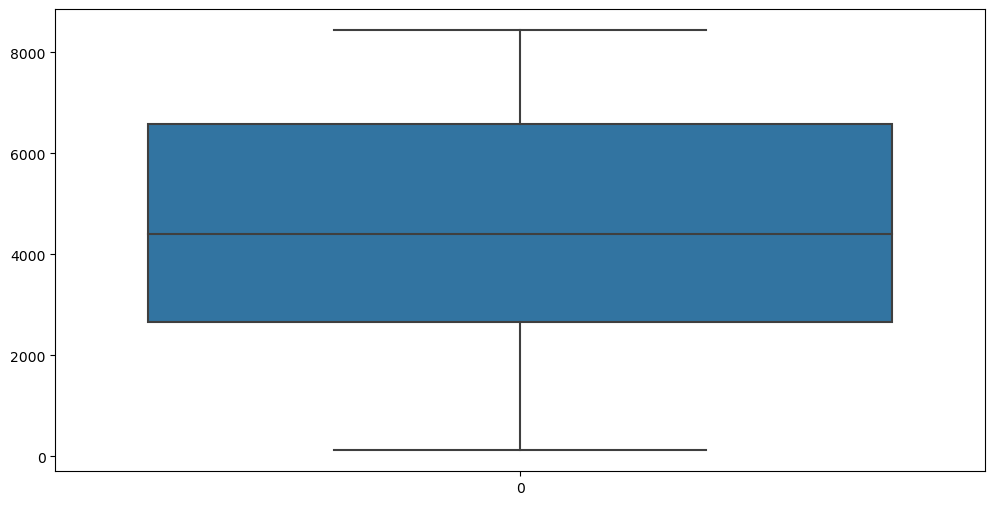

In [18]:
comparacion_bd_rem = pd.merge(
    cantidad_consultas_por_anio, resumen_rem, left_index=True, right_index=True
).iloc[:, [0, -1]].reset_index()

comparacion_bd_rem.columns = ["year", "consultas_bd", "consultas_rem"]
comparacion_bd_rem["dif"] = (
    comparacion_bd_rem.consultas_bd - comparacion_bd_rem.consultas_rem
)

promedio_diferencias_bd_rem = comparacion_bd_rem.dif.mean()
minimo_diferencias_bd_rem = comparacion_bd_rem.dif.min()
maximo_diferencias_bd_rem = comparacion_bd_rem.dif.max()

print(f"La comparacion de la base de datos con REM es: \n{comparacion_bd_rem}\n")
print(f"Hay una diferencia promedio de {promedio_diferencias_bd_rem:.0f} consultas entre la base "
      f"de datos y REM, con un minimo de {minimo_diferencias_bd_rem} y un maximo de "
      f"{maximo_diferencias_bd_rem} consultas. La distribucion de la diferencia entre ambas "
      f"bases es:")

sns.boxplot(comparacion_bd_rem["dif"])
plt.show()

## Diagnosticos mas relevantes entre 2016 y 2023

Posteriormemnte, se quieren seleccionar los 20 diagnósticos más frecuentes para cada uno de los
años. Luego, se generará una lista conteniendo solamente los diagnósticos únicos de las listas
anteriores.

In [19]:
diags_mas_relevantes = (
    resultado_sociodemo["global"].groupby("ano").head(20).codigo_diagnostico.unique()
)
consultas_totales_mas_relevantes = resultado_sociodemo["global"][
    resultado_sociodemo["global"]["codigo_diagnostico"].isin(diags_mas_relevantes)
]

In [20]:
print(
    f"Los diagnosticos más relevantes para el Hospital del Tórax en el ámbito ambulatorio"
    f" son: \n{diags_mas_relevantes}"
)

print(f"> {len(diags_mas_relevantes)} diagnosticos")

Los diagnosticos más relevantes para el Hospital del Tórax en el ámbito ambulatorio son: 
['C34X' 'J841' 'G473' 'J450' 'I99X' 'J47X' 'J849' 'J449' 'C349' 'J848'
 'J84X' 'I50X' 'F17X' 'C341' 'I441' 'I498' 'J459' 'R91X' 'I49X' 'D381'
 'I459' 'XXXX' 'I350' 'J432' 'I255' 'Q208' 'Z942' 'C340' 'J67X' 'E849'
 'R060' 'Z941']
> 32 diagnosticos


In [21]:
resumen_consultas_mas_relevantes = pd.pivot_table(
    consultas_totales_mas_relevantes,
    values="conteo_global",
    index=["codigo_diagnostico", "Descripción"],
    columns="ano",
    aggfunc=np.sum,
)

resumen_consultas_totales = pd.pivot_table(
    resultado_sociodemo["global"],
    values="conteo_global",
    index=["codigo_diagnostico", "Descripción"],
    columns="ano",
    aggfunc=np.sum,
)

comparacion_total_mas_relevantes = pd.concat(
    [resumen_consultas_mas_relevantes.sum(), resumen_consultas_totales.sum()],
    axis=1,
    keys=["Mas Relevantes", "Totales"],
)
comparacion_total_mas_relevantes["porcentaje_del_total"] = (
    comparacion_total_mas_relevantes["Mas Relevantes"]
    / comparacion_total_mas_relevantes["Totales"]
)

diccionario_resultado = {
    "diagnosticos_mas_relevantes": resumen_consultas_mas_relevantes,
    "comparacion_del_total": comparacion_total_mas_relevantes,
    "totales": resumen_consultas_totales,
    "BD_mas_relevantes": consultas_totales_mas_relevantes,
}

with pd.ExcelWriter(
    "../data/interim/diagnosticos_mas_relevantes_ambulatorios.xlsx"
) as file:
    for nombre_hoja, df_a_guardar in diccionario_resultado.items():
        df_a_guardar.to_excel(file, sheet_name=nombre_hoja)

In [22]:
display(comparacion_total_mas_relevantes)
display(resultado_sociodemo["global"].groupby("ano")["codigo_diagnostico"].nunique())

,Mas Relevantes,Totales,porcentaje_del_total
ano,,,
2016,23868.0,37578.0,0.635159
2017,25690.0,40039.0,0.641624
2018,27511.0,41194.0,0.667840
2019,25506.0,38401.0,0.664201
2020,18320.0,27798.0,0.659040
2021,25008.0,37320.0,0.670096
2022,23294.0,35413.0,0.657781
2023,4.0,4.0,1.000000


ano
2016    1022
2017     967
2018     925
2019     928
2020     780
2021     874
2022     889
2023       3
Name: codigo_diagnostico, dtype: int64

- En la tabla anterior se muestran la cantidad de diagnosticos distintos por año en las consultas
ambulatorias

- Los resultados anteriores indican que los 20 diagnosticos mas frecuentes entre 2016 y 2023
cubren aproximadamente el 66% de todas las consultas anuales.

- Esto significa que 32 (aproximadamente el 3% al 4% de los diagnosticos totales) diagnosticos
tienen una cobertura del 66% de las consultas totales del ambito ambulatorio

## 3. Análisis de Procedimientos por Diagnósticos

En este apartado se quieren responder las siguientes preguntas:

- ¿Cuál es la canasta de procedimientos que deben tener los pacientes para cada diagnósticos?
Por ejemplo: ¿Cuántas tomografías se debe tener un paciente que tenga una insuficiencia aórtica?

- ¿Existe alguna canasta de procedimientos distinta para pacientes con un mismo diagnóstico?


Uno de los problemas que existe al responder esta pregunta, es que la base de datos estadísticos/procedimientos
carece de un diagnóstico para el paciente. 

El problema anterior puede ser resuelto utilizando la base de datos de consultas ambulatoria. La
lógica de la resolución es la siguiente:

1. Se utilizará la base de datos de procedimientos como base principal.
2. La base anterior será filtrada dejando solamente pacientes que hayan tenido una consulta ambulatoria.
3. Luego, a cada dulpa de paciente-procedimiento se la asignará un diagnóstico. Para asignar el
diagnóstico se seguiran los siguientes pasos:
    1. Se obtendrá la fecha en que el paciente se realizó el procedimiento
    2. Desde la base de consultas ambulatorias, se encontrará la consulta más próxima a la fecha
    del procedimiento.
    3. Una vez encontrada la consulta más próxima al procedimiento, se asignará el diagnóstico
    asociado a tal consulta.

Una vez aplicado los pasos anterior, se obtendrá una base de datos donde se relaciona el diagnóstico
y los procedimientos realizados.

### 3.1 Obtención de pacientes con procedimientos Y consultas

In [52]:
pacientes_en_consultas = df_diagnosticos["id_paciente"].unique()
pacientes_en_procedimientos = df_procedimientos["id_paciente"].unique()


pacientes_con_proced_y_consultas = df_procedimientos[
    df_procedimientos["id_paciente"].isin(pacientes_en_consultas)
]

lista_pacientes_con_proced_y_consultas = pacientes_con_proced_y_consultas["id_paciente"].unique()

print(f"> Pacientes en Consultas: {len(pacientes_en_consultas)}")
print(f"> Pacientes en Procedimientos: {len(pacientes_en_procedimientos)}")
print(f"> Pacientes con Procedimientos y Consultas: {len(lista_pacientes_con_proced_y_consultas)}")

> Pacientes en Consultas: 45834
> Pacientes en Procedimientos: 14737
> Pacientes con Procedimientos y Consultas: 12572


Por lo tanto, existen **2165** (14737 - 12572) pacientes que tuvieron un procedimiento pero ninguna
consulta en el Instituto Nacional del Tórax. Tales pacientes deben ser filtrados, ya que nunca
se les podrá asignar un diagnóstico.

### 3.2 Obtención de diagnóstico para cada procedimiento realizado por un paciente

Una vez se han dejado solamente los pacientes a los que se les puede asignar un diagnóstico,
se debe proceder a asignar un diagnóstico. Para lo anterior, se deben obtener todas las sesiones
únicas de procedimientos para un paciente.

In [60]:
sesiones_unicas_proced = (
    pacientes_con_proced_y_consultas[["id_paciente", "fecha_realizacion"]].value_counts().index
)

print(sesiones_unicas_proced[3])

('05a6529a8f3d115b94309d594a2733b960d1c8fa1bceb50f95facfda6cd24e52', Timestamp('2020-11-23 00:00:00'))


La lista muestra todas las sesiones distintas de procedimientos que se ha realizado un paciente.
Con el paciente, y la fecha en que se realizó el procedimiento es posible buscar en la BD de
consultas ambulatorias para asignar un diagnóstico a tal sesión.

In [69]:
consultas_pacientes_con_proced = df_diagnosticos[
    df_diagnosticos["id_paciente"].isin(lista_pacientes_con_proced_y_consultas)
]

Para efectos de coste computacional, solamente se dejan las consultas de pacientes que tengan
procedimiento.

In [70]:
sesiones_procedimientos_con_diagnosticos = build_features.asignar_diagnosticos_a_procedimientos(
    sesiones_unicas_proced, consultas_pacientes_con_proced
)

Se buscaran los datos de 24646 sesiones unicas de proceds.
932ad74d428172e5d429b2159beef53400919dcebc49150b2c5a506c722ece3b
6f7a131fd8366fd3fd8dd4c2ee6d5b97e593dad3e57ebc0847d6fa538b6db042
a04a2915798986338d2ba7501c40f44149d7562bfe3b7b48bd4d6c240bbb97ca
05a6529a8f3d115b94309d594a2733b960d1c8fa1bceb50f95facfda6cd24e52
ea3c0c31981a1e539abd96d0ccf4e6a77c7be04e21eab1a720445f96393d0d86
cb14550283f6695bb1c64b25bbb9774d05d81e47abcd6b17c08d4afa03cb28ce
f0373859f5e92e694eaf543112c33d69432489c7786f0d637ca2fdf0f3cc524c
9814f1b100c74c9914870ff92320df7b4763414b86f2405a563f722700da56fb
fa7b58bfaab41467f8073cf4226e8217c0da9e4fda350add6fa35b7288702486
f4b28676b27234263d6955895c968e33c12e0134f4046c7aae20935fefb9506b
e44fd7e7d7520c50a51959434d5db6723d6ba168da8baa47fad0de85408efc7c
ae372575199b2f049283df19940e84e1e117acfdc87db550b20649402ef72fc6
48b39a98e631105248fc4207d157e5f741eb50e8d5f3262c51a486a0f5a8fea0
b0d8a5451d0c83d3567d7b7c37cd41687cd3155b6b884c1cbab4892b24905653
ab484b1d53510fa5685b09d4f3a7863

In [26]:
resultados_pacientes = []
for id_paciente, fecha_procedimiento in dupla_pacientes:
    df_paciente = diags_pacientes_comunes.query("id_paciente == @id_paciente")
    diag_mas_cercano = build_features.obtener_diag_mas_cercano(
        df_paciente, fecha_procedimiento
    )
    resultados_pacientes.append(diag_mas_cercano)

In [27]:
pacientes_y_diags = pd.DataFrame(resultados_pacientes, index=dupla_pacientes)
pacientes_y_diags.columns = ["codigo_diagnostico"]
proced_comunes_indice = proced_pacientes_comunes.set_index(
    ["id_paciente", "fecha_realizacion"]
)
union_procedimientos_2 = pd.merge(
    proced_comunes_indice,
    pacientes_y_diags,
    how="inner",
    left_index=True,
    right_index=True,
).reset_index()

In [63]:
pacientes_con_proced_y_consultas.set_index(["id_paciente", "fecha_realizacion"])

,,sexo,edad,prevision,servicio_salud,comuna_residencia,unidad_que_la_realiza,subtipo,cod,glosa,cerrado/abierto,mes,ano,year,month,day
id_paciente,fecha_realizacion,,,,,,,,,,,,,,,
cdae9cabd91d0e0741c5951c8ef47a8f895b6feeb56107dc2a8c22169b436e9b,2020-01-02,Masculino,53,Beneficiario D,Concepción,Coronel,BRONCOSCOPÍA,",",17 07 021,LARINGOTRAQUEOBRONCOSCOPIA CON FIBROSCOPIO,ABIERTA,01.ENERO,2020.0,2020.0,1.0,2.0
7bb5d19fc96147b8fdfea2eab5f1defd8d1e82465eb9951c052017d97b8e5a35,2020-01-02,Masculino,63,NO ACLARADA,Libertador Bernardo O´Higgins,Marchihue,IMAGENOLOGÍA,ULTRASONOGRAFÍA,04 04 003,"ECOGRAFIA ABDOMINAL (INCLUYE HIGADO, VIA BILIA...",ABIERTA,01.ENERO,2020.0,2020.0,1.0,2.0
7e9ebbc9f629c9afdd02b75da17302cd041078bbfd277dc0d0e506cea67b407b,2020-01-02,Masculino,46,Beneficiario B,Metropolitano Oriente (SSMO),Ñuñoa,ELECTROFISIOLOGÍA,",",17 01 006,"E.C.G. CONTINUO (TEST HOLTER O SIMILARES, POR ...",ABIERTA,01.ENERO,2020.0,2020.0,1.0,2.0
7bb5d19fc96147b8fdfea2eab5f1defd8d1e82465eb9951c052017d97b8e5a35,2020-01-02,Masculino,63,NO ACLARADA,Libertador Bernardo O´Higgins,Marchihue,IMAGENOLOGÍA,TOMOGRAFÍA,04 03 013,TOMOGRAFIA COMPUTARIZADA DE TORAX. INCLUYE ADE...,ABIERTA,01.ENERO,2020.0,2020.0,1.0,2.0
473a856217deb3af1d9600ee3dcb42ed0ff8d866eec464ab5b459d56b8e0c773,2020-01-02,Masculino,65,Beneficiario B,Metropolitano Oriente (SSMO),Estación Central,BRONCOSCOPÍA,",",17 07 021,LARINGOTRAQUEOBRONCOSCOPIA CON FIBROSCOPIO,ABIERTA,01.ENERO,2020.0,2020.0,1.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3feb00693d572a8a1b8c123de8256bf2a4cf69aa25dfd8ddd617d1820fad5453,2022-08-31,Femenino,61,Beneficiario B,Metropolitano Central (SSMC),Santiago,IMAGENOLOGÍA,SIMPLE,04 01 009,RADIOGRAFIA DE TORAX SIMPLE FRONTAL O LATERAL,ABIERTA,08.AGOSTO,2022.0,2022.0,8.0,31.0
cb8ef492e8decb83b838e8a0b197f94e8368a01563840dce10619f991c2baaf4,2022-08-31,Femenino,66,Beneficiario B,NaN,Los Andes,IMAGENOLOGÍA,TOMOGRAFÍA,04 03 013,TOMOGRAFIA COMPUTARIZADA DE TORAX. INCLUYE ADE...,ABIERTA,08.AGOSTO,2022.0,2022.0,8.0,31.0
d6dcfb50c0199b11d52c18c5a5810818565422d7c5a3ef0cccfa0e39de7a60f0,2022-08-31,Masculino,20,Beneficiario B,Metropolitano Oriente (SSMO),Ñuñoa,ELECTROFISIOLOGÍA,",",17 01 046,ESTUDIO ELECTROFISIOLÓGICO ENDOCARDÍACO DE LAS...,ABIERTA,08.AGOSTO,2022.0,2022.0,8.0,31.0


In [28]:
union_procedimientos_2["llave_sesion"] = union_procedimientos_2[
    "id_paciente"
] + union_procedimientos_2["fecha_realizacion"].astype(str)

In [29]:
cantidad_procedimientos_por_diagnostico = (
    union_procedimientos_2.groupby(["codigo_diagnostico"])["glosa"]
    .value_counts()
    .reset_index(name="cantidad_procedimientos_diag")
)

cantidad_sesiones_unicas_por_diagnostico = (
    union_procedimientos_2.groupby(["codigo_diagnostico"])["llave_sesion"]
    .nunique()
    .reset_index(name="sesiones_unicas_diag")
)

procedimientos_por_sesiones_unicas = pd.merge(
    cantidad_procedimientos_por_diagnostico,
    cantidad_sesiones_unicas_por_diagnostico,
    how="left",
    on="codigo_diagnostico",
)
procedimientos_por_sesiones_unicas["porcentaje_de_procedimiento_por_sesion"] = round(
    (
        procedimientos_por_sesiones_unicas["cantidad_procedimientos_diag"]
        / procedimientos_por_sesiones_unicas["sesiones_unicas_diag"]
    )
    * 100,
    2,
)

In [30]:
procedimientos_de_diags_mas_relevantes = procedimientos_por_sesiones_unicas[
    procedimientos_por_sesiones_unicas["codigo_diagnostico"].isin(diags_mas_relevantes)
]
procedimientos_de_diags_mas_relevantes.to_csv(
    "../data/interim/procedimientos_por_diagnostico.csv",
    index=False,
    encoding="latin-1",
)

In [31]:
cantidad_pacientes_unicos_por_diagnostico = (
    union_procedimientos_2.groupby("codigo_diagnostico")["id_paciente"]
    .nunique()
    .reset_index(name="numero_pacientes_distintos")
)

In [32]:
procedimientos_por_pacientes_distintos = pd.merge(
    cantidad_procedimientos_por_diagnostico,
    cantidad_pacientes_unicos_por_diagnostico,
    how="left",
    on="codigo_diagnostico"
)

procedimientos_por_pacientes_distintos["porcentaje_proced_por_paciente"] = round(
    (
        procedimientos_por_pacientes_distintos["cantidad_procedimientos_diag"] /
        procedimientos_por_pacientes_distintos["numero_pacientes_distintos"]
    ) * 100,
    2,
)

In [33]:
procedimientos_por_pacientes_distintos

,codigo_diagnostico,glosa,cantidad_procedimientos_diag,numero_pacientes_distintos,porcentaje_proced_por_paciente
0,17,TOMOGRAFIA COMPUTARIZADA DE TORAX. INCLUYE ADE...,4,3,133.33
1,17,ECOCARDIOGRAMA BIDIMENSIONAL DOPPLER COLOR,1,3,33.33
2,200-10,RADIOGRAFÍA DE TÓRAX FRONTAL Y LATERAL,3,4,75.00
3,200-10,"E.C.G. CONTINUO (TEST HOLTER O SIMILARES, POR ...",2,4,50.00
4,200-10,ECOCARDIOGRAMA BIDIMENSIONAL DOPPLER COLOR,1,4,25.00
...,...,...,...,...,...
4372,Z955,TOMOGRAFIA COMPUTARIZADA DE CALCIO CORONARIO,1,57,1.75
4373,Z959,ANGIOPLASTIA INTRALUMINAL CORONARIA UNO O MULT...,3,4,75.00
4374,Z959,ANGIOPLASTIA INTRALUMINAL CORONARIA UNO O MULT...,1,4,25.00
4375,Z959,ARTERIOGRAFIA SELECTIVA O SUPERSELECTIVA (PULM...,1,4,25.00


In [34]:
union_procedimientos_2.query("codigo_diagnostico == '200-10'").set_index("id_paciente")

,fecha_realizacion,sexo,edad,prevision,servicio_salud,comuna_residencia,unidad_que_la_realiza,subtipo,cod,glosa,cerrado/abierto,mes,ano,year,month,day,codigo_diagnostico,llave_sesion
id_paciente,,,,,,,,,,,,,,,,,,
4eb35fbdbae35f8ec332c969fec12b92f0d16b649ed631a9ccea1be33b69e94f,2020-09-11,Femenino,36,Beneficiario C,Metropolitano Oriente (SSMO),Ñuñoa,ELECTROFISIOLOGÍA,",",17 01 006,"E.C.G. CONTINUO (TEST HOLTER O SIMILARES, POR ...",ABIERTA,09.SEPTIEMBRE,2020.0,2020.0,9.0,11.0,200-10,4eb35fbdbae35f8ec332c969fec12b92f0d16b649ed631...
4eb35fbdbae35f8ec332c969fec12b92f0d16b649ed631a9ccea1be33b69e94f,2020-09-11,Femenino,36,Beneficiario C,Metropolitano Oriente (SSMO),Ñuñoa,ELECTROFISIOLOGÍA,",",17 01 006,"E.C.G. CONTINUO (TEST HOLTER O SIMILARES, POR ...",ABIERTA,09.SEPTIEMBRE,2020.0,2020.0,9.0,11.0,200-10,4eb35fbdbae35f8ec332c969fec12b92f0d16b649ed631...
4eb35fbdbae35f8ec332c969fec12b92f0d16b649ed631a9ccea1be33b69e94f,2020-09-15,Femenino,36,Beneficiario C,Metropolitano Oriente (SSMO),Ñuñoa,ELECTROFISIOLOGÍA,",",17 01 045,ECOCARDIOGRAMA BIDIMENSIONAL DOPPLER COLOR,ABIERTA,09.SEPTIEMBRE,2020.0,2020.0,9.0,15.0,200-10,4eb35fbdbae35f8ec332c969fec12b92f0d16b649ed631...
b821701af0830a1d0b43b56251906795eb1375abfc727b53a05cc3e849e017b4,2021-07-06,Masculino,18,Beneficiario B,Metropolitano Occidente (SSMOC),El Monte,IMAGENOLOGÍA,SIMPLE,04 01 070,RADIOGRAFÍA DE TÓRAX FRONTAL Y LATERAL,ABIERTA,07.JULIO,2021.0,2021.0,7.0,6.0,200-10,b821701af0830a1d0b43b56251906795eb1375abfc727b...
f4e56f1fa13ae7dc427aec3034a6fa595b747ea65ca0a1ee9693eb928959e723,2021-06-09,Femenino,20,Beneficiario A,Metropolitano Central (SSMC),Santiago,IMAGENOLOGÍA,SIMPLE,04 01 070,RADIOGRAFÍA DE TÓRAX FRONTAL Y LATERAL,ABIERTA,06.JUNIO,2021.0,2021.0,6.0,9.0,200-10,f4e56f1fa13ae7dc427aec3034a6fa595b747ea65ca0a1...
fab0efa2de6ecb03d0fadeae70e75dfed9b7410b34cb5b432110136a93c00022,2021-05-05,Femenino,44,Beneficiario D,Metropolitano Occidente (SSMOC),Cerro Navia,IMAGENOLOGÍA,SIMPLE,04 01 070,RADIOGRAFÍA DE TÓRAX FRONTAL Y LATERAL,ABIERTA,05.MAYO,2021.0,2021.0,5.0,5.0,200-10,fab0efa2de6ecb03d0fadeae70e75dfed9b7410b34cb5b...
